In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, roc_curve, auc
import os
import pandas as pd
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # You can change the seed number

In [2]:
# Define dataset paths
data_dir = r"C:\Users\dev\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray"
batch_size = 100
img_height = 256
img_width = 256

In [3]:
from torchvision.datasets import ImageFolder

# Function to calculate mean and std
def calculate_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_images_count = 0
    for images, _ in loader:
        images = images.view(images.size(0), images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += images.size(0)
    mean /= total_images_count
    std /= total_images_count
    return mean, std

# Load datasets 
# ['train', 'val', 'test']

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

datasets = {x: ImageFolder(root=os.path.join(data_dir, x), transform=transform) for x in ['train']}
loaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=False) for x in ['train']}

# Calculate mean and std for each dataset
mean_std = {x: calculate_mean_std(loaders[x]) for x in ['train']}
target_mean = mean_std['train'][0].numpy()[0]
target_std = mean_std['train'][1].numpy()[0]
print(target_mean,target_std)

0.47574726 0.22447172


In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[target_mean], std=[target_std])
])

In [6]:
from torch.utils.data import Dataset
from PIL import Image
import cv2

class CustomDataset(Dataset):
    def __init__(self, image_dir, cache_dir, img_height, img_width, target_mean, target_std, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.cache_dir = cache_dir
        self.img_height = img_height
        self.img_width = img_width
        self.target_mean = target_mean
        self.target_std = target_std
        os.makedirs(cache_dir, exist_ok=True)
        # Cache processed images and labels
        self._cache_data()

        self.images = []
        self.labels = []
        self.classes = os.listdir(self.cache_dir)
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.cache_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.images.append(img_path)
                self.labels.append(class_idx)
        
    def _cache_data(self):
        """Caches preprocessed images and labels as tensors."""
        self.classes = os.listdir(self.image_dir)
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.image_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                    
                cache_class_path = os.path.join(self.cache_dir,class_name)
                os.makedirs(cache_class_path, exist_ok=True)

                cache_img_path = os.path.join(cache_class_path, img_name)
                
                if not os.path.exists(cache_img_path):
                            
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                    # Compute sum of grayscale values along x-axis (rows)
                    gray_sum_rows = np.sum(img, axis=1)
                    
                    # Compute sum of grayscale values along y-axis (columns)
                    gray_sum_columns = np.sum(img, axis=0)
                    
                    # Calculate CDF of gray_sum_rows
                    gray_sum_rows_cdf = np.cumsum(gray_sum_rows) / np.sum(gray_sum_rows)
                    
                    # Calculate CDF of gray_sum_columns
                    gray_sum_columns_cdf = np.cumsum(gray_sum_columns) / np.sum(gray_sum_columns)
                    
                    # Find the indices for 0.1 and 0.9 CDF for x and y
                    x_min = np.searchsorted(gray_sum_columns_cdf, 0.05)
                    x_max = np.searchsorted(gray_sum_columns_cdf, 0.95)
                    y_min = np.searchsorted(gray_sum_rows_cdf, 0.15)
                    y_max = np.searchsorted(gray_sum_rows_cdf, 0.95)
                    
                    # Crop the image
                    img_crop = img[ y_min:y_max,x_min:x_max]
                    img_crop = cv2.resize(img_crop, (self.img_height,self.img_width))
                        
                    # Compute mean and standard deviation
                    mean_gray = np.mean(img_crop)
                    std_gray = np.std(img_crop)
                    
                    # Normalize image
                    norm_img = (img_crop - mean_gray) / std_gray  # Standardize
                    norm_img = (norm_img * self.target_std*255) + self.target_mean*255  # Scale to new distribution
                    
                    # Clip values to valid range
                    norm_img = np.clip(norm_img, 0, 255).astype(np.uint8)
                    cv2.imwrite(cache_img_path,norm_img)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        cache_img_path = self.images[idx]
        label = self.labels[idx]
        
        img_pil = Image.open(cache_img_path)

        if self.transform:
            image = self.transform(img_pil)
        
        return image, label

# Create custom dataset and data loader
train_dataset = CustomDataset(
    image_dir=os.path.join(data_dir, "train"), 
    cache_dir=os.path.join(data_dir, "train_cache"), 
    img_width=img_width,
    img_height=img_height,
    target_mean=target_mean, 
    target_std=target_std, 
    transform=transform)
test_dataset = CustomDataset(
    image_dir=os.path.join(data_dir, "test"), 
    cache_dir=os.path.join(data_dir, "test_cache"), 
    img_width=img_width,
    img_height=img_height,
    target_mean=target_mean, 
    target_std=target_std, 
    transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [7]:
# Class names
class_names = train_dataset.classes
print("Class Names:", class_names)

Class Names: ['NORMAL', 'PNEUMONIA']


In [8]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * (img_height // 8) * (img_width // 8), 128)
        # self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

In [9]:
# Initialize model
model = CNN(num_classes=len(class_names))
# model = torchvision.models.mobilenet_v3_large(pretrained=False)
# model.features[0][0] = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)
# model.classifier[3] = nn.Linear(model.classifier[3].in_features, len(class_names))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [10]:
# Train the model
epochs = 20
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    ## update step
    # for images, labels in train_loader:
    #     images, labels = images.to(device), labels.to(device)
    #     optimizer.zero_grad()
    #     outputs = model(images)
    #     loss = criterion(outputs, labels)
    #     loss.backward()
    #     optimizer.step()
    #     running_loss += loss.item()
    #     _, predicted = torch.max(outputs, 1)
    #     total += labels.size(0)
    #     correct += (predicted == labels).sum().item()

    ## update epoch

    optimizer.zero_grad()
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
    
    optimizer.step()



    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    scheduler.step()
    
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()[:, 1])
    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/20 - Train Loss: 0.6919, Train Acc: 0.5000, Val Loss: 0.6491, Val Acc: 0.7925
Epoch 2/20 - Train Loss: 0.6299, Train Acc: 0.8790, Val Loss: 0.5882, Val Acc: 0.7725
Epoch 3/20 - Train Loss: 0.5489, Train Acc: 0.8255, Val Loss: 0.5670, Val Acc: 0.7700
Epoch 4/20 - Train Loss: 0.4975, Train Acc: 0.9000, Val Loss: 0.5263, Val Acc: 0.8150
Epoch 5/20 - Train Loss: 0.4531, Train Acc: 0.9105, Val Loss: 0.5091, Val Acc: 0.8150
Epoch 6/20 - Train Loss: 0.4374, Train Acc: 0.8965, Val Loss: 0.5032, Val Acc: 0.8100
Epoch 7/20 - Train Loss: 0.4189, Train Acc: 0.9125, Val Loss: 0.5131, Val Acc: 0.7975
Epoch 8/20 - Train Loss: 0.4091, Train Acc: 0.9185, Val Loss: 0.5189, Val Acc: 0.7900
Epoch 9/20 - Train Loss: 0.4032, Train Acc: 0.9165, Val Loss: 0.5105, Val Acc: 0.8000
Epoch 10/20 - Train Loss: 0.3954, Train Acc: 0.9240, Val Loss: 0.5027, Val Acc: 0.7975
Epoch 11/20 - Train Loss: 0.3914, Train Acc: 0.9265, Val Loss: 0.5026, Val Acc: 0.7975
Epoch 12/20 - Train Loss: 0.3911, Train Acc: 0.9260,

In [11]:
# Classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

              precision  recall  f1-score   support
NORMAL         0.858896  0.7000  0.771350  200.0000
PNEUMONIA      0.746835  0.8850  0.810069  200.0000
accuracy       0.792500  0.7925  0.792500    0.7925
macro avg      0.802866  0.7925  0.790709  400.0000
weighted avg   0.802866  0.7925  0.790709  400.0000


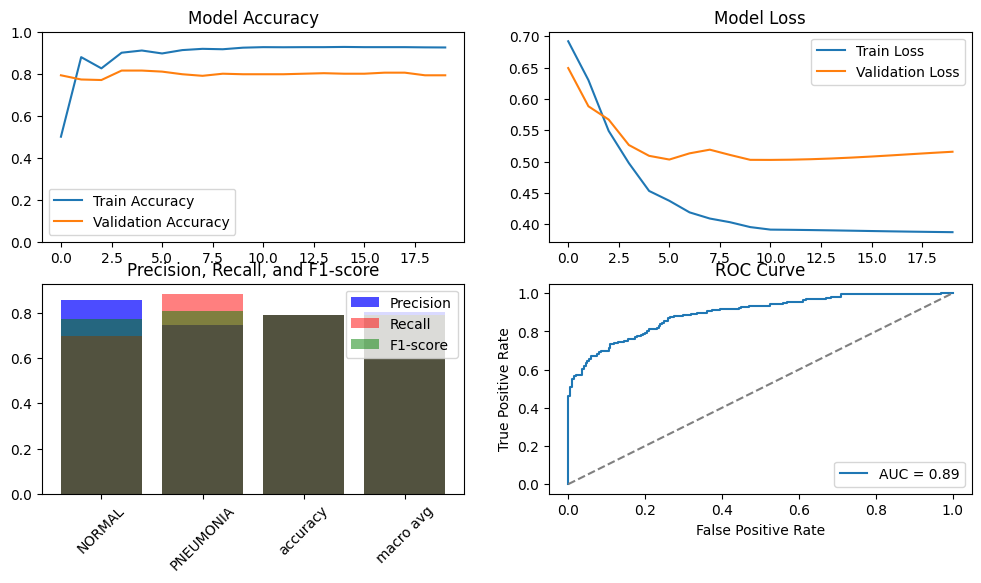

In [12]:
# Plot metrics
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.title("Model Accuracy")

plt.subplot(2, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title("Model Loss")

plt.subplot(2, 2, 3)
# sns.barplot(x=df_report.index[:-1], y=df_report['precision'][:-1], label='Precision', color='blue')
# sns.barplot(x=df_report.index[:-1], y=df_report['recall'][:-1], label='Recall', color='red', alpha=0.5)
# sns.barplot(x=df_report.index[:-1], y=df_report['f1-score'][:-1], label='F1-score', color='green', alpha=0.5)
plt.bar(df_report.index[:-1], df_report['precision'][:-1], color='blue', alpha=0.7, label='Precision')
plt.bar(df_report.index[:-1], df_report['recall'][:-1], color='red', alpha=0.5, label='Recall')
plt.bar(df_report.index[:-1], df_report['f1-score'][:-1], color='green', alpha=0.5, label='F1-score')
plt.xticks(rotation=45)
plt.legend()
plt.title("Precision, Recall, and F1-score")

plt.subplot(2, 2, 4)
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")
plt.show()


In [13]:
# Save the model
torch.save(model.state_dict(), "xray_classifier.pth")
print("Model saved as xray_classifier.pth")

Model saved as xray_classifier.pth
